In [1]:
%load_ext autoreload
%autoreload 2

save_path = "../../data"
import os
os.chdir("../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scvi.dataset import SpatialDataset, PreFrontalCortexStarmapDataset
from scvi.dataset import CortexDataset, RetinaDataset, SyntheticDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE

import torch
%matplotlib inline

import scanpy as sc
import anndata

[2019-12-10 10:20:42,075] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


## Loading data


In [53]:
%%time 

data = PreFrontalCortexStarmapDataset()
dataset = SpatialDataset()
dataset.populate_from_spatial_data(data.X, labels=data.labels, 
                                   cell_types=data.cell_types, coords=data.Spatial_coordinates, 
                                   gene_names=data.gene_names)

k_neighbors = 50
dataset.equip(k_neighbors)

[2019-12-10 12:14:42,835] INFO - scvi.dataset.dataset | File /home/romain/PycharmProjects/scVI-harmo/data/mpfc-starmap.loom already downloaded
[2019-12-10 12:14:42,836] INFO - scvi.dataset.loom | Preprocessing dataset
[2019-12-10 12:14:42,902] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2019-12-10 12:14:42,907] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-10 12:14:42,909] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-10 12:14:42,913] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-10 12:14:42,915] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


CPU times: user 2min 56s, sys: 43.7 s, total: 3min 40s
Wall time: 30.7 s


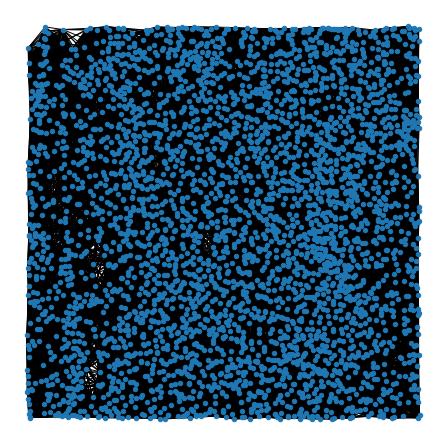

In [54]:
# visualizing the graph used
from sklearn.neighbors import NearestNeighbors
import networkx as nx
M = NearestNeighbors().fit(dataset.coords).kneighbors_graph(dataset.coords, 
                                                                    n_neighbors=k_neighbors + 1).toarray()
plt.figure(figsize=(6, 6))
g = nx.from_numpy_matrix((M + M.T > 0).astype(np.double))
nx.draw(g, data.Spatial_coordinates, node_size=20)
plt.show()
assert(nx.number_connected_components(g) == 1)

In [55]:
np.any(dataset.laplacian.T != dataset.laplacian)

False

In [56]:
np.any(np.sum(dataset.laplacian, axis=0) != 0)

False

In [57]:
inv_laplacian = np.linalg.pinv(dataset.laplacian)

In [58]:
res = 0
edge_res = 0
for i, j in zip(np.where(dataset.laplacian != 0)[0],np.where(dataset.laplacian != 0)[1]):
    if i < j:
        edge_res += 1
        entry = inv_laplacian[i, i] + inv_laplacian[j, j] - inv_laplacian[i, j] - inv_laplacian[j, i]
        res += entry
# PERFECT!

In [59]:
edge_res, 3704 * k_neighbors, res, dataset.laplacian.shape[0]

(100787, 185200, 3702.9999999999895, 3704)

# Running scVI

In [61]:
vae = VAE(data.nb_genes, n_layers=2, n_latent=30, reconstruction_loss="nb")
trainer_vae = UnsupervisedTrainer(vae, dataset, n_epochs_kl_warmup=None)
trainer_vae.train(n_epochs=200)

full_vae = trainer_vae.create_posterior(trainer_vae.model, dataset, indices=np.arange(len(dataset)))
latent_vae, _, _ = full_vae.sequential().get_latent()

training: 100%|██████████| 200/200 [00:51<00:00,  4.24it/s]


In [62]:
trainer_vae.train_set.elbo()

186.9442385449186

In [63]:
def proximity_metric(latent, laplacian):
    """
    calculates the metric in the corr vae paper using a point estimate.
    Bigger means that points next to each other in the graph are less next to each other in the latent space
    """
    u = np.where(dataset.laplacian != 0)[0]
    v = np.where(dataset.laplacian != 0)[1]
    diff = latent[u] - latent[v]
    return np.mean(diff**2)

In [64]:
proximity_metric(latent_vae, dataset.laplacian)

0.24047548

# Running CVAE

In [65]:
from scvi.models import CVAE
from scvi.inference.spatial import SpatialPosterior, SpatialUnsupervisedTrainer

In [67]:
model = CVAE(n_input=dataset.nb_genes, tau=0.99, n_layers=2, n_latent=30, reconstruction_loss="nb")
trainer = SpatialUnsupervisedTrainer(model, dataset, train_size=0.99, cut_minibatch=0.25, 
                                     data_loader_kwargs={"batch_size":512}, n_samples=dataset.X.shape[0], 
                                     n_edges=edge_res)

In [68]:
trainer.train(n_epochs=400)
print(trainer.train_set.elbo())

training:   0%|          | 0/400 [00:00<?, ?it/s] LOSS: 2123.757080078125, RECONS: 592.5150756835938, KL: 1531.2418805625991, KL_Z: 1.2241480350494385, KL_P: 56.229331970214844
 LOSS: 1968.96826171875, RECONS: 476.76715087890625, KL: 1492.2012028171487, KL_Z: 1.115609049797058, KL_P: 54.798545837402344
 LOSS: 1937.505615234375, RECONS: 501.89715576171875, KL: 1435.6084080071996, KL_Z: 1.1127381324768066, KL_P: 52.71882247924805
 LOSS: 1916.14111328125, RECONS: 515.5496215820312, KL: 1400.5915639766092, KL_Z: 1.0816946029663086, KL_P: 51.433067321777344
 LOSS: 1861.5223388671875, RECONS: 503.2827453613281, KL: 1358.2394819833805, KL_Z: 0.9977508783340454, KL_P: 49.87968063354492
 LOSS: 1861.3240966796875, RECONS: 539.2867431640625, KL: 1322.0373374022881, KL_Z: 1.032601237297058, KL_P: 48.547943115234375
 LOSS: 1835.86474609375, RECONS: 544.405029296875, KL: 1291.4597213801246, KL_Z: 1.0418833494186401, KL_P: 47.423851013183594
 LOSS: 1911.941650390625, RECONS: 649.8264770507812, KL: 12

 LOSS: 726.2359008789062, RECONS: 463.059814453125, KL: 263.1761444938363, KL_Z: 12.69197940826416, KL_P: 9.205486297607422
 LOSS: 576.2193603515625, RECONS: 317.9267272949219, KL: 258.2925984890363, KL_Z: 12.995119094848633, KL_P: 9.014871597290039
training:   2%|▏         | 8/400 [00:02<02:18,  2.84it/s] LOSS: 603.6690063476562, RECONS: 354.707275390625, KL: 248.96176078355597, KL_Z: 13.025663375854492, KL_P: 8.670833587646484
 LOSS: 605.1659545898438, RECONS: 364.72857666015625, KL: 240.43737260955456, KL_Z: 13.483660697937012, KL_P: 8.340723991394043
 LOSS: 613.8862915039062, RECONS: 376.4580383300781, KL: 237.428227073688, KL_Z: 13.864282608032227, KL_P: 8.216147422790527
 LOSS: 582.54541015625, RECONS: 352.59259033203125, KL: 229.9528263959205, KL_Z: 14.372564315795898, KL_P: 7.922740936279297
 LOSS: 599.6285400390625, RECONS: 374.61492919921875, KL: 225.01363929365934, KL_Z: 14.639486312866211, KL_P: 7.731412410736084
 LOSS: 563.966796875, RECONS: 347.13604736328125, KL: 216.830

 LOSS: 393.5230712890625, RECONS: 330.3145751953125, KL: 63.208477365565095, KL_Z: 29.035362243652344, KL_P: 1.2558883428573608
 LOSS: 380.7548828125, RECONS: 319.88177490234375, KL: 60.87305530030321, KL_Z: 28.687034606933594, KL_P: 1.182861089706421
 LOSS: 386.5752258300781, RECONS: 326.71173095703125, KL: 59.863534662816235, KL_Z: 29.79289436340332, KL_P: 1.105119228363037
 LOSS: 398.9835205078125, RECONS: 340.70269775390625, KL: 58.2808029308883, KL_Z: 30.246023178100586, KL_P: 1.0302997827529907
training:   4%|▍         | 16/400 [00:05<01:50,  3.46it/s] LOSS: 392.4181213378906, RECONS: 332.4259948730469, KL: 59.99211153268943, KL_Z: 29.96570587158203, KL_P: 1.103493571281433
 LOSS: 391.2519226074219, RECONS: 334.1411437988281, KL: 57.110792220169856, KL_Z: 30.635164260864258, KL_P: 0.9729997515678406
 LOSS: 379.8743591308594, RECONS: 323.59442138671875, KL: 56.27996212676908, KL_Z: 30.351089477539062, KL_P: 0.95290607213974
 LOSS: 400.8548278808594, RECONS: 343.86077880859375, KL:

 LOSS: 354.12469482421875, RECONS: 323.6076354980469, KL: 30.517074515089618, KL_Z: 39.784339904785156, KL_P: -0.34057915210723877
 LOSS: 340.5539855957031, RECONS: 310.0138854980469, KL: 30.540087438685333, KL_Z: 39.442508697509766, KL_P: -0.32717084884643555
 LOSS: 352.45635986328125, RECONS: 322.7689514160156, KL: 29.687412686718396, KL_Z: 39.96198272705078, KL_P: -0.377598375082016
 LOSS: 378.6658020019531, RECONS: 349.33563232421875, KL: 29.33021282923627, KL_Z: 39.59672546386719, KL_P: -0.37730225920677185
 LOSS: 350.5887145996094, RECONS: 322.123779296875, KL: 28.464969873122598, KL_Z: 39.69831848144531, KL_P: -0.4128342270851135
 LOSS: 345.6831359863281, RECONS: 314.83770751953125, KL: 30.84544297038994, KL_Z: 39.53982162475586, KL_P: -0.3195251226425171
training:   6%|▌         | 24/400 [00:07<01:45,  3.55it/s] LOSS: 364.5018005371094, RECONS: 334.731201171875, KL: 29.77060218034694, KL_Z: 40.242801666259766, KL_P: -0.38486140966415405
 LOSS: 342.82940673828125, RECONS: 314.16

training:   8%|▊         | 31/400 [00:09<01:47,  3.42it/s] LOSS: 352.68377685546875, RECONS: 331.21356201171875, KL: 21.470237987313105, KL_Z: 46.601646423339844, KL_P: -0.9235986471176147
 LOSS: 347.51885986328125, RECONS: 326.66851806640625, KL: 20.850351120158223, KL_Z: 46.60474395751953, KL_P: -0.9464938044548035
 LOSS: 336.64520263671875, RECONS: 315.6055908203125, KL: 21.03963146534131, KL_Z: 46.58435821533203, KL_P: -0.9387884140014648
 LOSS: 324.29559326171875, RECONS: 303.26025390625, KL: 21.035312222996744, KL_Z: 46.121726989746094, KL_P: -0.9219450950622559
 LOSS: 341.9881286621094, RECONS: 321.50885009765625, KL: 20.479259097968786, KL_Z: 46.26960372924805, KL_P: -0.9478150606155396
 LOSS: 317.9476013183594, RECONS: 297.38629150390625, KL: 20.561315500517384, KL_Z: 45.882205963134766, KL_P: -0.9305622577667236
 LOSS: 320.1073913574219, RECONS: 299.3774719238281, KL: 20.729922768476843, KL_Z: 46.70342254638672, KL_P: -0.9545461535453796
 LOSS: 289.78448486328125, RECONS: 271

 LOSS: 317.72540283203125, RECONS: 299.7486572265625, KL: 17.976804840770704, KL_Z: 50.077911376953125, KL_P: -1.1797404289245605
 LOSS: 327.484619140625, RECONS: 310.5469055175781, KL: 16.937734213941297, KL_Z: 49.82117462158203, KL_P: -1.2084918022155762
 LOSS: 329.4316101074219, RECONS: 311.9256591796875, KL: 17.50591862713415, KL_Z: 51.39296340942383, KL_P: -1.2453750371932983
training:  10%|▉         | 39/400 [00:11<01:40,  3.58it/s] LOSS: 331.2926025390625, RECONS: 313.62359619140625, KL: 17.66899944520022, KL_Z: 50.82878875732422, KL_P: -1.218647837638855
 LOSS: 320.7451171875, RECONS: 303.3986511230469, KL: 17.346493079743425, KL_Z: 50.901912689208984, KL_P: -1.2331875562667847
 LOSS: 347.8450012207031, RECONS: 329.4569091796875, KL: 18.388118513910094, KL_Z: 51.42814636230469, KL_P: -1.2142465114593506
 LOSS: 332.7887268066406, RECONS: 315.6427001953125, KL: 17.14601611827156, KL_Z: 50.356040954589844, KL_P: -1.220494031906128
 LOSS: 317.7781677246094, RECONS: 299.671112060546

 LOSS: 325.29010009765625, RECONS: 308.4117431640625, KL: 16.87836681695788, KL_Z: 53.61565399169922, KL_P: -1.350123643875122
 LOSS: 308.01123046875, RECONS: 291.925537109375, KL: 16.085717163320233, KL_Z: 53.18081283569336, KL_P: -1.3632733821868896
 LOSS: 333.7700500488281, RECONS: 316.2201232910156, KL: 17.54994551538134, KL_Z: 54.015220642089844, KL_P: -1.3401269912719727
 LOSS: 312.7045593261719, RECONS: 295.83258056640625, KL: 16.871985054363698, KL_Z: 53.87841033935547, KL_P: -1.3600146770477295
 LOSS: 304.40283203125, RECONS: 288.2494812011719, KL: 16.15335609150757, KL_Z: 53.18968200683594, KL_P: -1.3611135482788086
 LOSS: 339.0327453613281, RECONS: 319.9357604980469, KL: 19.096985103984885, KL_Z: 54.011329650878906, KL_P: -1.283129096031189
training:  12%|█▏        | 47/400 [00:14<01:44,  3.37it/s] LOSS: 307.5901794433594, RECONS: 290.48876953125, KL: 17.101396249096283, KL_Z: 53.77147674560547, KL_P: -1.3476537466049194
 LOSS: 330.6947021484375, RECONS: 314.39605712890625, 

training:  14%|█▎        | 54/400 [00:15<01:24,  4.10it/s] LOSS: 317.26226806640625, RECONS: 301.4608154296875, KL: 15.801506143377097, KL_Z: 55.13865280151367, KL_P: -1.445670485496521
 LOSS: 295.64105224609375, RECONS: 279.94500732421875, KL: 15.69605295298939, KL_Z: 54.8497314453125, KL_P: -1.4389278888702393
 LOSS: 322.4208068847656, RECONS: 305.2569885253906, KL: 17.163824215949738, KL_Z: 56.09275817871094, KL_P: -1.4306683540344238
 LOSS: 312.2913513183594, RECONS: 296.30419921875, KL: 15.987152143765734, KL_Z: 55.615821838378906, KL_P: -1.4563841819763184
 LOSS: 301.3985290527344, RECONS: 285.36663818359375, KL: 16.031868885937058, KL_Z: 56.029151916503906, KL_P: -1.4699310064315796
 LOSS: 316.343994140625, RECONS: 299.419677734375, KL: 16.924263661900298, KL_Z: 55.90364074707031, KL_P: -1.432522177696228
 LOSS: 309.4601135253906, RECONS: 293.5440368652344, KL: 15.916067085275124, KL_Z: 55.04322814941406, KL_P: -1.4379533529281616
 LOSS: 311.3288879394531, RECONS: 297.3014831542

 LOSS: 293.9742431640625, RECONS: 277.4869689941406, KL: 16.487268470533465, KL_Z: 56.23173904418945, KL_P: -1.4606399536132812
 LOSS: 307.76397705078125, RECONS: 290.0044250488281, KL: 17.759563757971605, KL_Z: 57.550575256347656, KL_P: -1.4623503684997559
training:  16%|█▌        | 62/400 [00:17<01:19,  4.27it/s] LOSS: 305.790771484375, RECONS: 289.5179443359375, KL: 16.272801729792135, KL_Z: 55.9148063659668, KL_P: -1.4568742513656616
 LOSS: 302.64385986328125, RECONS: 286.7058410644531, KL: 15.937990928281977, KL_Z: 56.37553787231445, KL_P: -1.486111044883728
 LOSS: 298.083740234375, RECONS: 280.84405517578125, KL: 17.23968440329668, KL_Z: 57.037776947021484, KL_P: -1.4626106023788452
 LOSS: 289.233154296875, RECONS: 273.1419677734375, KL: 16.09120963146954, KL_Z: 56.32782745361328, KL_P: -1.4787267446517944
 LOSS: 288.84307861328125, RECONS: 273.135009765625, KL: 15.70807638638864, KL_Z: 56.327972412109375, KL_P: -1.4928125143051147
 LOSS: 307.4540710449219, RECONS: 290.9852600097

 LOSS: 287.1425476074219, RECONS: 269.3132019042969, KL: 17.82936757091698, KL_Z: 57.56803512573242, KL_P: -1.460426688194275
 LOSS: 304.1441345214844, RECONS: 286.92742919921875, KL: 17.216697672981418, KL_Z: 57.74230194091797, KL_P: -1.489347219467163
 LOSS: 294.512451171875, RECONS: 277.2558288574219, KL: 17.25663844549115, KL_Z: 57.41554641723633, KL_P: -1.4758708477020264
 LOSS: 260.8819580078125, RECONS: 243.6379852294922, KL: 17.24398289463175, KL_Z: 56.84809112548828, KL_P: -1.4554815292358398
training:  18%|█▊        | 70/400 [00:19<01:16,  4.34it/s] LOSS: 286.5359191894531, RECONS: 269.94598388671875, KL: 16.58992929360779, KL_Z: 57.27526092529297, KL_P: -1.4952173233032227
 LOSS: 297.15277099609375, RECONS: 280.6975402832031, KL: 16.45524618676491, KL_Z: 57.418548583984375, KL_P: -1.5054329633712769
 LOSS: 306.30645751953125, RECONS: 290.464111328125, KL: 15.842313886718664, KL_Z: 57.33577346801758, KL_P: -1.524916648864746
 LOSS: 307.41082763671875, RECONS: 290.997741699218

 LOSS: 294.23822021484375, RECONS: 277.30950927734375, KL: 16.92869297648351, KL_Z: 58.636932373046875, KL_P: -1.5328099727630615
 LOSS: 283.05694580078125, RECONS: 266.9100036621094, KL: 16.146942313591552, KL_Z: 58.10474395751953, KL_P: -1.54198157787323
 LOSS: 284.2242126464844, RECONS: 267.32562255859375, KL: 16.898601360120217, KL_Z: 58.351566314697266, KL_P: -1.5234284400939941
 LOSS: 318.8493957519531, RECONS: 303.1821594238281, KL: 15.66725954278241, KL_Z: 57.05248260498047, KL_P: -1.5209388732910156
 LOSS: 297.21783447265625, RECONS: 280.51092529296875, KL: 16.706920250188197, KL_Z: 58.1885986328125, KL_P: -1.5244836807250977
 LOSS: 334.8957824707031, RECONS: 320.34588623046875, KL: 14.549909980746378, KL_Z: 56.251502990722656, KL_P: -1.532565712928772
training:  20%|█▉        | 78/400 [00:21<01:13,  4.39it/s] LOSS: 297.7525634765625, RECONS: 281.5242004394531, KL: 16.228351315205863, KL_Z: 58.02983474731445, KL_P: -1.5362367630004883
 LOSS: 290.7203369140625, RECONS: 274.1796

training:  21%|██▏       | 85/400 [00:23<01:12,  4.34it/s] LOSS: 285.6824035644531, RECONS: 268.5125427246094, KL: 17.16986076228047, KL_Z: 58.867149353027344, KL_P: -1.532407522201538
 LOSS: 296.8760681152344, RECONS: 280.65374755859375, KL: 16.222314973050004, KL_Z: 58.59437561035156, KL_P: -1.5572059154510498
 LOSS: 290.0984802246094, RECONS: 273.37835693359375, KL: 16.72014815165595, KL_Z: 58.73762130737305, KL_P: -1.5441745519638062
 LOSS: 299.55682373046875, RECONS: 283.7142333984375, KL: 15.842596474367134, KL_Z: 58.13289260864258, KL_P: -1.5542010068893433
 LOSS: 284.71392822265625, RECONS: 268.22015380859375, KL: 16.493793177778464, KL_Z: 58.63001251220703, KL_P: -1.5485385656356812
 LOSS: 296.2886047363281, RECONS: 281.1507568359375, KL: 15.137818497857054, KL_Z: 57.67940902709961, KL_P: -1.5634362697601318
 LOSS: 286.3318786621094, RECONS: 270.17706298828125, KL: 16.154848616787476, KL_Z: 58.371917724609375, KL_P: -1.5515098571777344
 LOSS: 258.1045837402344, RECONS: 241.101

 LOSS: 300.6762390136719, RECONS: 284.487060546875, KL: 16.189189349279033, KL_Z: 58.46546936035156, KL_P: -1.5536859035491943
 LOSS: 299.9329528808594, RECONS: 283.8643493652344, KL: 16.068620102966833, KL_Z: 58.53013610839844, KL_P: -1.5604934692382812
 LOSS: 321.5484619140625, RECONS: 304.5387878417969, KL: 17.00971441492277, KL_Z: 58.305965423583984, KL_P: -1.5176690816879272
training:  23%|██▎       | 93/400 [00:25<01:29,  3.44it/s] LOSS: 300.415771484375, RECONS: 284.7661437988281, KL: 15.649620932134646, KL_Z: 58.054962158203125, KL_P: -1.5584290027618408
 LOSS: 294.57672119140625, RECONS: 278.402587890625, KL: 16.174126335856208, KL_Z: 58.5941162109375, KL_P: -1.5589673519134521
 LOSS: 289.5595397949219, RECONS: 272.9822998046875, KL: 16.57723621270955, KL_Z: 58.933963775634766, KL_P: -1.5566424131393433
 LOSS: 299.30523681640625, RECONS: 283.41729736328125, KL: 15.88793496475364, KL_Z: 58.16753005981445, KL_P: -1.5538077354431152
 LOSS: 273.59295654296875, RECONS: 256.96466064

 LOSS: 291.6990966796875, RECONS: 274.792236328125, KL: 16.906872147875262, KL_Z: 59.320640563964844, KL_P: -1.5587387084960938
 LOSS: 266.68206787109375, RECONS: 250.48641967773438, KL: 16.1956390520602, KL_Z: 58.556453704833984, KL_P: -1.5567926168441772
 LOSS: 302.9854431152344, RECONS: 286.4303283691406, KL: 16.555088128886517, KL_Z: 59.33692169189453, KL_P: -1.572265386581421
 LOSS: 275.88800048828125, RECONS: 259.85955810546875, KL: 16.028448633415138, KL_Z: 58.87403106689453, KL_P: -1.5746082067489624
 LOSS: 296.6545104980469, RECONS: 280.5755920410156, KL: 16.078907610530727, KL_Z: 59.401878356933594, KL_P: -1.5921525955200195
 LOSS: 303.9450378417969, RECONS: 285.205810546875, KL: 18.739248077085414, KL_Z: 60.847999572753906, KL_P: -1.5475291013717651
training:  25%|██▌       | 101/400 [00:27<01:26,  3.46it/s] LOSS: 295.1612548828125, RECONS: 279.39013671875, KL: 15.771119744132712, KL_Z: 58.661231994628906, KL_P: -1.5762447118759155
 LOSS: 276.2008361816406, RECONS: 259.82092

 LOSS: 281.1510925292969, RECONS: 265.9453430175781, KL: 15.20576577419596, KL_Z: 58.4219856262207, KL_P: -1.5882294178009033
training:  27%|██▋       | 108/400 [00:29<01:30,  3.22it/s] LOSS: 267.16680908203125, RECONS: 250.4733123779297, KL: 16.693476811437577, KL_Z: 59.23564147949219, KL_P: -1.5634573698043823
 LOSS: 261.1280212402344, RECONS: 244.4920654296875, KL: 16.635946254557716, KL_Z: 59.676719665527344, KL_P: -1.5817816257476807
 LOSS: 299.1138916015625, RECONS: 282.714111328125, KL: 16.399818220547928, KL_Z: 58.882476806640625, KL_P: -1.5612704753875732
 LOSS: 273.3258361816406, RECONS: 257.40887451171875, KL: 15.916961989250858, KL_Z: 58.3922119140625, KL_P: -1.5609982013702393
 LOSS: 279.8025207519531, RECONS: 263.61724853515625, KL: 16.185261447344686, KL_Z: 58.70587158203125, KL_P: -1.5626652240753174
 LOSS: 270.86395263671875, RECONS: 254.34779357910156, KL: 16.51615094855331, KL_Z: 58.958282470703125, KL_P: -1.5597810745239258
 LOSS: 283.02642822265625, RECONS: 266.940

 LOSS: 265.623291015625, RECONS: 246.81661987304688, KL: 18.806681317786158, KL_Z: 58.92292785644531, KL_P: -1.4743030071258545
 LOSS: 279.39178466796875, RECONS: 260.0347595214844, KL: 19.357026905143236, KL_Z: 59.6595344543457, KL_P: -1.4811482429504395
 LOSS: 292.4110107421875, RECONS: 275.13104248046875, KL: 17.279962165759912, KL_Z: 59.1380615234375, KL_P: -1.5383174419403076
training:  29%|██▉       | 116/400 [00:32<01:30,  3.15it/s] LOSS: 262.3970642089844, RECONS: 243.83802795410156, KL: 18.55903201857602, KL_Z: 59.53156280517578, KL_P: -1.5057721138000488
 LOSS: 293.43817138671875, RECONS: 275.83837890625, KL: 17.599775867508498, KL_Z: 58.85054016113281, KL_P: -1.5159974098205566
 LOSS: 290.6495056152344, RECONS: 272.323486328125, KL: 18.325990764870753, KL_Z: 59.128089904785156, KL_P: -1.4995086193084717
 LOSS: 271.2795104980469, RECONS: 253.0274200439453, KL: 18.252071935949004, KL_Z: 59.72978973388672, KL_P: -1.5243381261825562
 LOSS: 273.3264465332031, RECONS: 255.24668884

 LOSS: 267.10601806640625, RECONS: 250.99508666992188, KL: 16.11091565052711, KL_Z: 59.11518096923828, KL_P: -1.5804399251937866
 LOSS: 288.5478820800781, RECONS: 271.8415832519531, KL: 16.706303103374353, KL_Z: 59.56162643432617, KL_P: -1.5749661922454834
 LOSS: 291.6323547363281, RECONS: 274.78472900390625, KL: 16.84764807811308, KL_Z: 59.56370544433594, KL_P: -1.5698480606079102
 LOSS: 266.6878967285156, RECONS: 249.50076293945312, KL: 17.18713264299263, KL_Z: 59.83734893798828, KL_P: -1.5674283504486084
 LOSS: 289.250244140625, RECONS: 271.7983703613281, KL: 17.451900198540727, KL_Z: 59.5498046875, KL_P: -1.5471304655075073
 LOSS: 243.25588989257812, RECONS: 227.49241638183594, KL: 15.76346209104581, KL_Z: 58.78097152709961, KL_P: -1.5809266567230225
training:  31%|███       | 124/400 [00:34<01:27,  3.14it/s] LOSS: 299.9459228515625, RECONS: 283.18450927734375, KL: 16.761389409877822, KL_Z: 58.96406936645508, KL_P: -1.550981044769287
 LOSS: 272.5382080078125, RECONS: 255.7805633544

 LOSS: 260.8937683105469, RECONS: 245.2736358642578, KL: 15.620133822313136, KL_Z: 59.17304229736328, KL_P: -1.6006029844284058
training:  33%|███▎      | 131/400 [00:37<01:16,  3.51it/s] LOSS: 260.0737609863281, RECONS: 243.02056884765625, KL: 17.053190559020052, KL_Z: 59.545528411865234, KL_P: -1.5616261959075928
 LOSS: 264.6744079589844, RECONS: 248.22476196289062, KL: 16.449620667820874, KL_Z: 59.4288444519043, KL_P: -1.5795196294784546
 LOSS: 298.0859069824219, RECONS: 281.4715576171875, KL: 16.614354838015707, KL_Z: 59.68743896484375, KL_P: -1.582969069480896
 LOSS: 278.51983642578125, RECONS: 261.7926025390625, KL: 16.72724134553843, KL_Z: 59.75029754638672, KL_P: -1.5811305046081543
 LOSS: 267.6479797363281, RECONS: 251.42584228515625, KL: 16.22212471676182, KL_Z: 59.60845184326172, KL_P: -1.5944809913635254
 LOSS: 274.7219543457031, RECONS: 257.84857177734375, KL: 16.87340233386464, KL_Z: 59.82876205444336, KL_P: -1.5786426067352295
 LOSS: 266.9923095703125, RECONS: 250.676086

 LOSS: 267.25299072265625, RECONS: 250.78167724609375, KL: 16.471326128420763, KL_Z: 59.35235595703125, KL_P: -1.5759109258651733
 LOSS: 268.037841796875, RECONS: 251.54733276367188, KL: 16.490504843595218, KL_Z: 59.15026092529297, KL_P: -1.5677789449691772
 LOSS: 264.35943603515625, RECONS: 248.04141235351562, KL: 16.31800617213254, KL_Z: 59.57451629638672, KL_P: -1.5897101163864136
 LOSS: 271.71673583984375, RECONS: 253.78616333007812, KL: 17.930602034662506, KL_Z: 60.227142333984375, KL_P: -1.5544304847717285
training:  35%|███▍      | 139/400 [00:39<01:14,  3.52it/s] LOSS: 273.2199401855469, RECONS: 256.0185852050781, KL: 17.201343698519608, KL_Z: 60.20439910888672, KL_P: -1.5803954601287842
 LOSS: 270.04754638671875, RECONS: 253.287841796875, KL: 16.759696722481216, KL_Z: 59.67322540283203, KL_P: -1.5771052837371826
 LOSS: 265.0244445800781, RECONS: 247.4963836669922, KL: 17.52807530728581, KL_Z: 59.568634033203125, KL_P: -1.545022964477539
 LOSS: 281.4169006347656, RECONS: 263.96

 LOSS: 259.6383972167969, RECONS: 243.7406005859375, KL: 15.89784321356283, KL_Z: 59.48295211791992, KL_P: -1.6017863750457764
 LOSS: 250.37359619140625, RECONS: 233.22671508789062, KL: 17.14690346140455, KL_Z: 60.22576141357422, KL_P: -1.5831812620162964
 LOSS: 272.75482177734375, RECONS: 256.34503173828125, KL: 16.409752815350345, KL_Z: 59.478736877441406, KL_P: -1.5828183889389038
 LOSS: 269.8665466308594, RECONS: 253.37313842773438, KL: 16.49341775177622, KL_Z: 59.85215377807617, KL_P: -1.5934669971466064
 LOSS: 271.189208984375, RECONS: 255.22024536132812, KL: 15.968965131314732, KL_Z: 59.23518371582031, KL_P: -1.590066909790039
 LOSS: 268.20574951171875, RECONS: 251.77554321289062, KL: 16.430235094694545, KL_Z: 59.63653564453125, KL_P: -1.587864875793457
 LOSS: 315.43170166015625, RECONS: 298.3638916015625, KL: 17.06776725772776, KL_Z: 59.99345016479492, KL_P: -1.5775519609451294
training:  37%|███▋      | 147/400 [00:41<01:11,  3.52it/s] LOSS: 254.96127319335938, RECONS: 238.518

 LOSS: 281.24676513671875, RECONS: 265.3770446777344, KL: 15.869694221805034, KL_Z: 58.85383224487305, KL_P: -1.579700231552124
 LOSS: 239.5076141357422, RECONS: 224.96817016601562, KL: 14.53946526065372, KL_Z: 57.76405715942383, KL_P: -1.5885370969772339
training:  38%|███▊      | 154/400 [00:43<01:08,  3.61it/s] LOSS: 267.79022216796875, RECONS: 251.20278930664062, KL: 16.587444651075366, KL_Z: 60.221073150634766, KL_P: -1.603569507598877
 LOSS: 276.6076354980469, RECONS: 260.1017150878906, KL: 16.50591510308999, KL_Z: 59.72066879272461, KL_P: -1.5881755352020264
 LOSS: 276.0567626953125, RECONS: 259.33966064453125, KL: 16.717070304484913, KL_Z: 59.683536529541016, KL_P: -1.5790507793426514
 LOSS: 258.9556579589844, RECONS: 242.3087921142578, KL: 16.646869657492793, KL_Z: 59.65941619873047, KL_P: -1.5807442665100098
 LOSS: 268.4741516113281, RECONS: 252.7063751220703, KL: 15.767755656662047, KL_Z: 58.92282485961914, KL_P: -1.585982084274292
 LOSS: 262.443359375, RECONS: 245.545959472

 LOSS: 259.3724060058594, RECONS: 242.30113220214844, KL: 17.071272476896098, KL_Z: 59.583072662353516, KL_P: -1.5623414516448975
 LOSS: 253.6760711669922, RECONS: 237.36990356445312, KL: 16.306155479559372, KL_Z: 59.724082946777344, KL_P: -1.595642328262329
 LOSS: 263.5295104980469, RECONS: 247.74151611328125, KL: 15.787996163378523, KL_Z: 58.89649200439453, KL_P: -1.5842704772949219
 LOSS: 234.69094848632812, RECONS: 220.65567016601562, KL: 14.035264922849045, KL_Z: 58.25166702270508, KL_P: -1.6249868869781494
training:  40%|████      | 162/400 [00:45<01:06,  3.56it/s] LOSS: 254.69924926757812, RECONS: 238.29888916015625, KL: 16.400341763030376, KL_Z: 59.20664596557617, KL_P: -1.573164701461792
 LOSS: 262.8779296875, RECONS: 245.71498107910156, KL: 17.162963671702286, KL_Z: 59.98579788208008, KL_P: -1.5737721920013428
 LOSS: 239.5752410888672, RECONS: 222.83746337890625, KL: 16.737778697718035, KL_Z: 60.036067962646484, KL_P: -1.5912455320358276
 LOSS: 269.78076171875, RECONS: 253.32

 LOSS: 272.1568298339844, RECONS: 255.92510986328125, KL: 16.231697114059784, KL_Z: 59.69706726074219, KL_P: -1.5973858833312988
 LOSS: 260.48583984375, RECONS: 244.57589721679688, KL: 15.9099281737601, KL_Z: 59.26506042480469, KL_P: -1.5933345556259155
 LOSS: 255.49734497070312, RECONS: 238.3416748046875, KL: 17.15568029178914, KL_Z: 60.0338134765625, KL_P: -1.5758044719696045
 LOSS: 268.669677734375, RECONS: 252.1710205078125, KL: 16.498629523469354, KL_Z: 59.41416931152344, KL_P: -1.577179193496704
 LOSS: 257.3123779296875, RECONS: 241.262451171875, KL: 16.049938693996637, KL_Z: 59.30978012084961, KL_P: -1.5898325443267822
 LOSS: 214.91476440429688, RECONS: 197.22715759277344, KL: 17.687607027767285, KL_Z: 60.448463439941406, KL_P: -1.571494460105896
training:  42%|████▎     | 170/400 [00:47<01:03,  3.62it/s] LOSS: 247.441162109375, RECONS: 231.00486755371094, KL: 16.436289065085013, KL_Z: 59.78941345214844, KL_P: -1.5932607650756836
 LOSS: 270.7472839355469, RECONS: 254.31518554687

training:  44%|████▍     | 177/400 [00:49<01:02,  3.55it/s] LOSS: 255.18115234375, RECONS: 237.95370483398438, KL: 17.227434141557367, KL_Z: 60.503211975097656, KL_P: -1.5904182195663452
 LOSS: 269.6134033203125, RECONS: 252.9739227294922, KL: 16.639483300192566, KL_Z: 59.962921142578125, KL_P: -1.5921697616577148
 LOSS: 256.0097351074219, RECONS: 239.61605834960938, KL: 16.393677529454486, KL_Z: 59.76449966430664, KL_P: -1.5939111709594727
 LOSS: 265.4740905761719, RECONS: 248.99420166015625, KL: 16.479912674774617, KL_Z: 59.980308532714844, KL_P: -1.5986731052398682
 LOSS: 264.616455078125, RECONS: 247.34078979492188, KL: 17.275713520579153, KL_Z: 60.749267578125, KL_P: -1.5976866483688354
 LOSS: 248.8429412841797, RECONS: 233.134765625, KL: 15.708187777782364, KL_Z: 59.22520446777344, KL_P: -1.5992839336395264
 LOSS: 262.49053955078125, RECONS: 245.72238159179688, KL: 16.768168067796957, KL_Z: 60.01018524169922, KL_P: -1.5891774892807007
 LOSS: 256.6184387207031, RECONS: 240.4368133

 LOSS: 273.2328796386719, RECONS: 256.3642883300781, KL: 16.868606220536563, KL_Z: 59.92282485961914, KL_P: -1.5822757482528687
 LOSS: 266.47412109375, RECONS: 249.41061401367188, KL: 17.063485302368967, KL_Z: 60.375038146972656, KL_P: -1.5917329788208008
 LOSS: 228.4026336669922, RECONS: 211.1785125732422, KL: 17.224085276894122, KL_Z: 60.13385772705078, KL_P: -1.5769672393798828
training:  46%|████▋     | 185/400 [00:52<01:05,  3.30it/s] LOSS: 268.9907531738281, RECONS: 252.34909057617188, KL: 16.641652620315035, KL_Z: 60.2149543762207, KL_P: -1.6013524532318115
 LOSS: 252.00999450683594, RECONS: 236.12008666992188, KL: 15.889923852508318, KL_Z: 59.33174133300781, KL_P: -1.5965203046798706
 LOSS: 277.24932861328125, RECONS: 260.7337646484375, KL: 16.515539879997142, KL_Z: 59.7456169128418, KL_P: -1.5887386798858643
 LOSS: 262.7168884277344, RECONS: 246.90731811523438, KL: 15.809589800708494, KL_Z: 59.28703308105469, KL_P: -1.5978295803070068
 LOSS: 254.67018127441406, RECONS: 238.686

 LOSS: 245.2958984375, RECONS: 228.45095825195312, KL: 16.844963178070778, KL_Z: 59.70927810668945, KL_P: -1.5752966403961182
 LOSS: 258.5753173828125, RECONS: 241.61105346679688, KL: 16.964268338313367, KL_Z: 59.90324401855469, KL_P: -1.5780404806137085
 LOSS: 249.01028442382812, RECONS: 232.51089477539062, KL: 16.499398115579815, KL_Z: 59.94754409790039, KL_P: -1.5967528820037842
 LOSS: 254.53204345703125, RECONS: 237.7764129638672, KL: 16.75562613874223, KL_Z: 59.96384048461914, KL_P: -1.587935209274292
 LOSS: 257.4896240234375, RECONS: 240.75418090820312, KL: 16.735436391302628, KL_Z: 60.108924865722656, KL_P: -1.5940091609954834
 LOSS: 235.90359497070312, RECONS: 219.7926788330078, KL: 16.110935439043885, KL_Z: 60.258174896240234, KL_P: -1.6224451065063477
training:  48%|████▊     | 193/400 [00:54<00:59,  3.47it/s] LOSS: 260.419677734375, RECONS: 244.34901428222656, KL: 16.070692170515947, KL_Z: 59.33758544921875, KL_P: -1.5900917053222656
 LOSS: 260.990234375, RECONS: 244.0884094

 LOSS: 263.40191650390625, RECONS: 246.41165161132812, KL: 16.990280061831484, KL_Z: 59.84906768798828, KL_P: -1.5750935077667236
training:  50%|█████     | 200/400 [00:56<00:57,  3.49it/s] LOSS: 263.786865234375, RECONS: 246.7550048828125, KL: 17.03186075502029, KL_Z: 60.03528594970703, KL_P: -1.580409049987793
 LOSS: 249.22621154785156, RECONS: 233.0705108642578, KL: 16.155670237689243, KL_Z: 59.45235061645508, KL_P: -1.5911864042282104
 LOSS: 278.7369689941406, RECONS: 262.03076171875, KL: 16.706173560982386, KL_Z: 59.575172424316406, KL_P: -1.5754687786102295
 LOSS: 259.9328308105469, RECONS: 242.90643310546875, KL: 17.026406133374437, KL_Z: 59.90650177001953, KL_P: -1.5758765935897827
 LOSS: 239.2462921142578, RECONS: 222.5560760498047, KL: 16.690240802955422, KL_Z: 59.977699279785156, KL_P: -1.5908474922180176
 LOSS: 260.95501708984375, RECONS: 244.58079528808594, KL: 16.374232208497062, KL_Z: 59.55255889892578, KL_P: -1.586836814880371
 LOSS: 255.0216827392578, RECONS: 238.69396

 LOSS: 272.9299011230469, RECONS: 257.43878173828125, KL: 15.49109639340034, KL_Z: 59.00815200805664, KL_P: -1.599285364151001
 LOSS: 260.7233581542969, RECONS: 243.6907958984375, KL: 17.032543552842306, KL_Z: 60.26804733276367, KL_P: -1.5889381170272827
 LOSS: 262.945556640625, RECONS: 246.4609832763672, KL: 16.4845820039382, KL_Z: 59.577491760253906, KL_P: -1.5836976766586304
 LOSS: 260.8360900878906, RECONS: 245.0508575439453, KL: 15.78523559514312, KL_Z: 59.14350128173828, KL_P: -1.5934497117996216
training:  52%|█████▏    | 208/400 [00:58<00:52,  3.62it/s] LOSS: 253.71133422851562, RECONS: 236.9427947998047, KL: 16.768554937826636, KL_Z: 60.439674377441406, KL_P: -1.6049473285675049
 LOSS: 273.9898376464844, RECONS: 257.8804931640625, KL: 16.10934211548667, KL_Z: 59.39987564086914, KL_P: -1.5909605026245117
 LOSS: 258.849609375, RECONS: 242.1785888671875, KL: 16.671021204144083, KL_Z: 59.69581604003906, KL_P: -1.5811944007873535
 LOSS: 254.3757781982422, RECONS: 238.13409423828125

 LOSS: 247.797607421875, RECONS: 231.26434326171875, KL: 16.53327562532852, KL_Z: 60.02534484863281, KL_P: -1.5983670949935913
 LOSS: 243.59307861328125, RECONS: 227.5676727294922, KL: 16.02541864636006, KL_Z: 59.36913299560547, KL_P: -1.5929149389266968
 LOSS: 243.56613159179688, RECONS: 227.67138671875, KL: 15.89472386910385, KL_Z: 59.223358154296875, KL_P: -1.5923607349395752
 LOSS: 242.65895080566406, RECONS: 226.22413635253906, KL: 16.43482018633872, KL_Z: 59.94805145263672, KL_P: -1.5991448163986206
 LOSS: 248.6814727783203, RECONS: 232.25350952148438, KL: 16.42797752101272, KL_Z: 59.829627990722656, KL_P: -1.5950441360473633
 LOSS: 258.1082458496094, RECONS: 241.6751251220703, KL: 16.433144487681965, KL_Z: 59.410675048828125, KL_P: -1.579457402229309
training:  54%|█████▍    | 216/400 [01:00<00:51,  3.58it/s] LOSS: 238.63519287109375, RECONS: 221.67510986328125, KL: 16.960066067992223, KL_Z: 60.18437576293945, KL_P: -1.588526725769043
 LOSS: 244.37759399414062, RECONS: 227.73103

training:  56%|█████▌    | 223/400 [01:02<00:47,  3.71it/s] LOSS: 250.11569213867188, RECONS: 233.87155151367188, KL: 16.24417301021178, KL_Z: 59.695640563964844, KL_P: -1.5968749523162842
 LOSS: 264.85491943359375, RECONS: 249.141357421875, KL: 15.713583911662482, KL_Z: 59.00551223754883, KL_P: -1.5910117626190186
 LOSS: 257.5786437988281, RECONS: 241.11119079589844, KL: 16.467441388134304, KL_Z: 59.717960357666016, KL_P: -1.5894899368286133
 LOSS: 260.8152160644531, RECONS: 244.25436401367188, KL: 16.560845310178223, KL_Z: 59.78642654418945, KL_P: -1.5885734558105469
 LOSS: 246.1730499267578, RECONS: 229.88893127441406, KL: 16.284138781945856, KL_Z: 59.52387237548828, KL_P: -1.589093565940857
 LOSS: 263.65203857421875, RECONS: 247.08448791503906, KL: 16.567566197904604, KL_Z: 59.44148254394531, KL_P: -1.5756494998931885
 LOSS: 248.6046905517578, RECONS: 232.8768768310547, KL: 15.72780934233645, KL_Z: 58.95219039916992, KL_P: -1.588529348373413
 LOSS: 238.01393127441406, RECONS: 219.9

 LOSS: 248.44125366210938, RECONS: 231.14419555664062, KL: 17.297041727161563, KL_Z: 60.32310485839844, KL_P: -1.5812410116195679
 LOSS: 253.19241333007812, RECONS: 236.8111114501953, KL: 16.381267085124293, KL_Z: 59.98381423950195, KL_P: -1.6024272441864014
 LOSS: 236.09735107421875, RECONS: 216.1324920654297, KL: 19.96483868212473, KL_Z: 61.93496322631836, KL_P: -1.5424344539642334
training:  58%|█████▊    | 231/400 [01:05<00:48,  3.49it/s] LOSS: 254.50439453125, RECONS: 237.37521362304688, KL: 17.129186836708953, KL_Z: 60.068214416503906, KL_P: -1.5780423879623413
 LOSS: 249.03981018066406, RECONS: 232.4930419921875, KL: 16.54673685699894, KL_Z: 59.374725341796875, KL_P: -1.573961615562439
 LOSS: 232.60101318359375, RECONS: 217.143798828125, KL: 15.457195931261097, KL_Z: 58.95817565917969, KL_P: -1.5986945629119873
 LOSS: 242.79393005371094, RECONS: 226.3272705078125, KL: 16.466641589001497, KL_Z: 60.12339782714844, KL_P: -1.604419469833374
 LOSS: 256.41796875, RECONS: 239.584503173

 LOSS: 242.3336181640625, RECONS: 224.95530700683594, KL: 17.378297188305183, KL_Z: 60.52532196044922, KL_P: -1.585686445236206
 LOSS: 252.0321502685547, RECONS: 234.86473083496094, KL: 17.167434956516352, KL_Z: 60.28042984008789, KL_P: -1.5844358205795288
 LOSS: 249.66946411132812, RECONS: 232.94920349121094, KL: 16.720283633657203, KL_Z: 60.129547119140625, KL_P: -1.595323920249939
 LOSS: 241.84910583496094, RECONS: 224.95077514648438, KL: 16.898357622759903, KL_Z: 59.78850555419922, KL_P: -1.5762460231781006
 LOSS: 236.952392578125, RECONS: 219.90078735351562, KL: 17.051584892924353, KL_Z: 60.20331954956055, KL_P: -1.5858595371246338
 LOSS: 241.5760498046875, RECONS: 225.97036743164062, KL: 15.605683335861428, KL_Z: 58.760616302490234, KL_P: -1.5859770774841309
training:  60%|█████▉    | 239/400 [01:07<00:44,  3.62it/s] LOSS: 253.0355682373047, RECONS: 236.81472778320312, KL: 16.22083454281413, KL_Z: 59.73811721801758, KL_P: -1.5992937088012695
 LOSS: 243.18553161621094, RECONS: 227

 LOSS: 243.55319213867188, RECONS: 226.2563018798828, KL: 17.296896291313367, KL_Z: 59.8390998840332, KL_P: -1.563458800315857
training:  62%|██████▏   | 246/400 [01:09<00:43,  3.54it/s] LOSS: 244.20004272460938, RECONS: 228.10641479492188, KL: 16.093656331172, KL_Z: 59.469078063964844, KL_P: -1.5940802097320557
 LOSS: 244.3089599609375, RECONS: 228.25155639648438, KL: 16.057393709056832, KL_Z: 59.470848083496094, KL_P: -1.5954779386520386
 LOSS: 231.8579559326172, RECONS: 214.90237426757812, KL: 16.95557492739696, KL_Z: 60.33211898803711, KL_P: -1.5941214561462402
 LOSS: 253.20034790039062, RECONS: 236.4613800048828, KL: 16.73897475287415, KL_Z: 59.78777313232422, KL_P: -1.5820765495300293
 LOSS: 233.47149658203125, RECONS: 217.12889099121094, KL: 16.34260866808711, KL_Z: 59.77629089355469, KL_P: -1.5962213277816772
 LOSS: 259.3124694824219, RECONS: 242.42977905273438, KL: 16.882695242794746, KL_Z: 60.19756317138672, KL_P: -1.5918548107147217
 LOSS: 249.50039672851562, RECONS: 232.606

 LOSS: 253.02330017089844, RECONS: 236.98455810546875, KL: 16.0387620589903, KL_Z: 59.35484313964844, KL_P: -1.5918993949890137
 LOSS: 255.15728759765625, RECONS: 238.03118896484375, KL: 17.126094583236885, KL_Z: 60.34759521484375, KL_P: -1.588423490524292
 LOSS: 265.248046875, RECONS: 248.5265655517578, KL: 16.721445126390613, KL_Z: 60.52546310424805, KL_P: -1.60983145236969
training:  64%|██████▎   | 254/400 [01:11<00:39,  3.67it/s] LOSS: 237.86758422851562, RECONS: 220.89666748046875, KL: 16.97091345080289, KL_Z: 59.634857177734375, KL_P: -1.5679328441619873
 LOSS: 238.70114135742188, RECONS: 221.93905639648438, KL: 16.76207483503525, KL_Z: 60.23310852050781, KL_P: -1.5975940227508545
 LOSS: 233.2330780029297, RECONS: 216.7752227783203, KL: 16.45785488909187, KL_Z: 59.87236022949219, KL_P: -1.595516562461853
 LOSS: 234.0147247314453, RECONS: 216.90042114257812, KL: 17.11429201549253, KL_Z: 60.22832489013672, KL_P: -1.584473967552185
 LOSS: 238.71530151367188, RECONS: 222.29116821289

 LOSS: 235.71949768066406, RECONS: 218.92822265625, KL: 16.791276311192085, KL_Z: 60.014801025390625, KL_P: -1.5884978771209717
 LOSS: 236.77281188964844, RECONS: 220.503173828125, KL: 16.26966547177497, KL_Z: 59.782066345214844, KL_P: -1.5991142988204956
 LOSS: 240.9995880126953, RECONS: 223.38829040527344, KL: 17.61130340989542, KL_Z: 60.62715530395508, KL_P: -1.580865740776062
 LOSS: 252.07992553710938, RECONS: 235.6128692626953, KL: 16.467073329517184, KL_Z: 59.826133728027344, KL_P: -1.5934789180755615
 LOSS: 228.26986694335938, RECONS: 211.8234100341797, KL: 16.446459341866664, KL_Z: 59.98047637939453, KL_P: -1.599908709526062
 LOSS: 230.3555908203125, RECONS: 214.11709594726562, KL: 16.238490519139987, KL_Z: 58.92132568359375, KL_P: -1.568627119064331
training:  66%|██████▌   | 262/400 [01:13<00:38,  3.63it/s] LOSS: 245.0404510498047, RECONS: 228.63294982910156, KL: 16.407499960058452, KL_Z: 59.65183639526367, KL_P: -1.5892627239227295
 LOSS: 246.33392333984375, RECONS: 230.4988

training:  67%|██████▋   | 269/400 [01:15<00:35,  3.68it/s] LOSS: 248.01077270507812, RECONS: 231.13616943359375, KL: 16.874570296598563, KL_Z: 59.90365982055664, KL_P: -1.5813522338867188
 LOSS: 240.86611938476562, RECONS: 223.9385528564453, KL: 16.927585576316964, KL_Z: 60.04285430908203, KL_P: -1.584519386291504
 LOSS: 240.83517456054688, RECONS: 224.29905700683594, KL: 16.53614178431858, KL_Z: 59.86368942260742, KL_P: -1.5923207998275757
 LOSS: 241.8472137451172, RECONS: 225.27810668945312, KL: 16.569099005046205, KL_Z: 59.93501663208008, KL_P: -1.5937309265136719
 LOSS: 227.81622314453125, RECONS: 211.3917236328125, KL: 16.424493932247678, KL_Z: 59.97612762451172, KL_P: -1.6005561351776123
 LOSS: 235.58514404296875, RECONS: 219.86317443847656, KL: 15.721964192699403, KL_Z: 59.04669952392578, KL_P: -1.5922174453735352
 LOSS: 247.982666015625, RECONS: 231.30712890625, KL: 16.675535202476944, KL_Z: 60.285919189453125, KL_P: -1.602715253829956
 LOSS: 251.73748779296875, RECONS: 235.23

 LOSS: 228.4482879638672, RECONS: 211.28912353515625, KL: 17.159150273895158, KL_Z: 60.42341613769531, KL_P: -1.5899951457977295
 LOSS: 247.06103515625, RECONS: 232.2774200439453, KL: 14.783631893490352, KL_Z: 58.845428466796875, KL_P: -1.6193050146102905
training:  69%|██████▉   | 277/400 [01:17<00:33,  3.63it/s] LOSS: 238.8045654296875, RECONS: 222.75729370117188, KL: 16.047250902260096, KL_Z: 59.533935546875, KL_P: -1.598169207572937
 LOSS: 236.16305541992188, RECONS: 219.75100708007812, KL: 16.412051240452932, KL_Z: 59.790340423583984, KL_P: -1.5941855907440186
 LOSS: 253.09613037109375, RECONS: 236.774169921875, KL: 16.321958347446973, KL_Z: 59.76729202270508, KL_P: -1.5966495275497437
 LOSS: 244.2696075439453, RECONS: 227.23582458496094, KL: 17.033793524840995, KL_Z: 60.11709213256836, KL_P: -1.5833444595336914
 LOSS: 254.09678649902344, RECONS: 237.78302001953125, KL: 16.313762228477337, KL_Z: 59.821128845214844, KL_P: -1.5989292860031128
 LOSS: 245.03785705566406, RECONS: 228.2

 LOSS: 259.9408264160156, RECONS: 243.22732543945312, KL: 16.713552412538753, KL_Z: 59.55817794799805, KL_P: -1.574573040008545
 LOSS: 223.72726440429688, RECONS: 207.3756561279297, KL: 16.351593648576326, KL_Z: 59.47217559814453, KL_P: -1.584714651107788
 LOSS: 243.13687133789062, RECONS: 226.73580932617188, KL: 16.401030148562548, KL_Z: 59.76988983154297, KL_P: -1.5938390493392944
 LOSS: 242.06640625, RECONS: 225.67337036132812, KL: 16.39303743871448, KL_Z: 59.66619110107422, KL_P: -1.5903217792510986
 LOSS: 235.1942596435547, RECONS: 217.36741638183594, KL: 17.826837406045158, KL_Z: 60.73606491088867, KL_P: -1.5769472122192383
training:  71%|███████▏  | 285/400 [01:19<00:31,  3.61it/s] LOSS: 242.56703186035156, RECONS: 226.3379669189453, KL: 16.229041435484234, KL_Z: 59.638755798339844, KL_P: -1.5953404903411865
 LOSS: 247.62989807128906, RECONS: 231.56800842285156, KL: 16.061880391791107, KL_Z: 59.612648010253906, KL_P: -1.6005243062973022
 LOSS: 236.33737182617188, RECONS: 219.735

training:  73%|███████▎  | 292/400 [01:21<00:30,  3.51it/s] LOSS: 226.7421112060547, RECONS: 209.56178283691406, KL: 17.18034521807347, KL_Z: 60.3416748046875, KL_P: -1.586212158203125
 LOSS: 228.40853881835938, RECONS: 211.79681396484375, KL: 16.61170316357206, KL_Z: 60.17715835571289, KL_P: -1.6010640859603882
 LOSS: 235.5857391357422, RECONS: 219.91357421875, KL: 15.672160012386016, KL_Z: 59.05443572998047, KL_P: -1.5943320989608765
 LOSS: 249.4036407470703, RECONS: 232.65194702148438, KL: 16.751677495196105, KL_Z: 59.86390686035156, KL_P: -1.5844076871871948
 LOSS: 252.4088592529297, RECONS: 236.34454345703125, KL: 16.064323653798894, KL_Z: 59.45872116088867, KL_P: -1.5947775840759277
 LOSS: 251.48187255859375, RECONS: 235.30950927734375, KL: 16.172377942962726, KL_Z: 59.21467590332031, KL_P: -1.5818376541137695
 LOSS: 238.6685791015625, RECONS: 222.3394317626953, KL: 16.32914969634031, KL_Z: 59.34654235839844, KL_P: -1.5809223651885986
 LOSS: 269.790283203125, RECONS: 256.29882812

 LOSS: 225.64991760253906, RECONS: 209.291259765625, KL: 16.358660114474482, KL_Z: 59.472381591796875, KL_P: -1.5844625234603882
 LOSS: 239.47695922851562, RECONS: 223.3253173828125, KL: 16.151612152226797, KL_Z: 59.48908233642578, KL_P: -1.5926854610443115
training:  75%|███████▌  | 300/400 [01:24<00:27,  3.63it/s] LOSS: 226.69326782226562, RECONS: 210.1607666015625, KL: 16.5325013974251, KL_Z: 59.91948699951172, KL_P: -1.5945051908493042
 LOSS: 244.16053771972656, RECONS: 227.49842834472656, KL: 16.66211938800101, KL_Z: 59.641197204589844, KL_P: -1.5795142650604248
 LOSS: 248.07774353027344, RECONS: 231.3957977294922, KL: 16.68195494600686, KL_Z: 60.04125213623047, KL_P: -1.5934876203536987
 LOSS: 239.01547241210938, RECONS: 222.03900146484375, KL: 16.976457646901096, KL_Z: 60.33458709716797, KL_P: -1.5934447050094604
 LOSS: 236.27066040039062, RECONS: 219.40826416015625, KL: 16.862402217627597, KL_Z: 59.928619384765625, KL_P: -1.582716703414917
 LOSS: 234.39666748046875, RECONS: 218

 LOSS: 224.86099243164062, RECONS: 208.78814697265625, KL: 16.07285276956486, KL_Z: 59.578399658203125, KL_P: -1.5988624095916748
 LOSS: 229.96571350097656, RECONS: 213.32998657226562, KL: 16.6357311831051, KL_Z: 59.81519317626953, KL_P: -1.5868785381317139
 LOSS: 225.4572296142578, RECONS: 209.63931274414062, KL: 15.817903455210036, KL_Z: 59.32881546020508, KL_P: -1.5990595817565918
 LOSS: 234.14071655273438, RECONS: 216.68569946289062, KL: 17.455038622633168, KL_Z: 60.48222732543945, KL_P: -1.581282377243042
 LOSS: 199.8083953857422, RECONS: 182.29263305664062, KL: 17.515748014943128, KL_Z: 60.88862991333008, KL_P: -1.5939868688583374
training:  77%|███████▋  | 308/400 [01:26<00:26,  3.45it/s] LOSS: 239.15536499023438, RECONS: 222.70248413085938, KL: 16.452869259834806, KL_Z: 60.04655456542969, KL_P: -1.6021015644073486
 LOSS: 242.14207458496094, RECONS: 225.9678497314453, KL: 16.17424086000183, KL_Z: 59.1767578125, KL_P: -1.5803756713867188
 LOSS: 234.91580200195312, RECONS: 219.124

training:  79%|███████▉  | 315/400 [01:28<00:25,  3.36it/s] LOSS: 245.5238037109375, RECONS: 228.43630981445312, KL: 17.087456482919194, KL_Z: 59.96319580078125, KL_P: -1.575716495513916
 LOSS: 241.92002868652344, RECONS: 225.71029663085938, KL: 16.209715934603054, KL_Z: 59.92302322387695, KL_P: -1.6064977645874023
 LOSS: 214.6307373046875, RECONS: 198.46868896484375, KL: 16.162060801462786, KL_Z: 59.53223419189453, KL_P: -1.5938873291015625
 LOSS: 242.12472534179688, RECONS: 225.8070526123047, KL: 16.317669646882855, KL_Z: 59.98701477050781, KL_P: -1.6048821210861206
 LOSS: 244.55471801757812, RECONS: 227.79495239257812, KL: 16.75975246508616, KL_Z: 60.32484436035156, KL_P: -1.6010507345199585
 LOSS: 236.02468872070312, RECONS: 220.19540405273438, KL: 15.82928852279938, KL_Z: 59.490394592285156, KL_P: -1.6045793294906616
 LOSS: 257.4510803222656, RECONS: 240.94766235351562, KL: 16.50340251215848, KL_Z: 59.96031951904297, KL_P: -1.5970752239227295
 LOSS: 232.009521484375, RECONS: 215.1

 LOSS: 236.96502685546875, RECONS: 220.85287475585938, KL: 16.112165854861615, KL_Z: 59.45124816894531, KL_P: -1.5927447080612183
 LOSS: 216.0397491455078, RECONS: 199.43731689453125, KL: 16.60243496060629, KL_Z: 59.470947265625, KL_P: -1.5754508972167969
training:  81%|████████  | 323/400 [01:30<00:22,  3.45it/s] LOSS: 226.7379150390625, RECONS: 210.5079803466797, KL: 16.229922855389553, KL_Z: 59.535377502441406, KL_P: -1.5915088653564453
 LOSS: 241.8727264404297, RECONS: 225.68592834472656, KL: 16.18682743946883, KL_Z: 59.41181182861328, KL_P: -1.5885515213012695
 LOSS: 233.2032470703125, RECONS: 216.43243408203125, KL: 16.77078863360454, KL_Z: 60.01768112182617, KL_P: -1.5893566608428955
 LOSS: 228.9188995361328, RECONS: 212.27650451660156, KL: 16.64239618584481, KL_Z: 59.71677780151367, KL_P: -1.5830167531967163
 LOSS: 243.1979217529297, RECONS: 226.4685821533203, KL: 16.729334284625864, KL_Z: 59.70758819580078, KL_P: -1.579483985900879
 LOSS: 223.9552459716797, RECONS: 206.6773223

 LOSS: 249.74783325195312, RECONS: 232.76657104492188, KL: 16.981247764619845, KL_Z: 60.12549591064453, KL_P: -1.5855844020843506
 LOSS: 234.22476196289062, RECONS: 217.11962890625, KL: 17.105147269451848, KL_Z: 60.14460372924805, KL_P: -1.581733226776123
 LOSS: 229.72962951660156, RECONS: 213.85006713867188, KL: 15.87953181217221, KL_Z: 59.10003662109375, KL_P: -1.5883868932724
 LOSS: 252.9547576904297, RECONS: 237.41720581054688, KL: 15.537565710542012, KL_Z: 59.05207824707031, KL_P: -1.5991919040679932
 LOSS: 282.7406311035156, RECONS: 266.9032897949219, KL: 15.837333994569583, KL_Z: 59.155513763427734, KL_P: -1.591976523399353
training:  83%|████████▎ | 331/400 [01:32<00:19,  3.50it/s] LOSS: 244.3875732421875, RECONS: 227.53521728515625, KL: 16.852348299636695, KL_Z: 60.1739501953125, KL_P: -1.592102289199829
 LOSS: 244.42234802246094, RECONS: 228.06802368164062, KL: 16.354327103070766, KL_Z: 59.674102783203125, KL_P: -1.592035174369812
 LOSS: 241.55352783203125, RECONS: 225.162384

training:  84%|████████▍ | 338/400 [01:34<00:16,  3.73it/s] LOSS: 230.41552734375, RECONS: 214.0240478515625, KL: 16.391467862394407, KL_Z: 59.61283874511719, KL_P: -1.58841872215271
 LOSS: 223.95472717285156, RECONS: 207.85633850097656, KL: 16.09839977349756, KL_Z: 59.492794036865234, KL_P: -1.5947774648666382
 LOSS: 230.53158569335938, RECONS: 214.220703125, KL: 16.31086751818657, KL_Z: 59.86132049560547, KL_P: -1.6005127429962158
 LOSS: 249.94522094726562, RECONS: 234.0972137451172, KL: 15.847995608948473, KL_Z: 59.388824462890625, KL_P: -1.6001590490341187
 LOSS: 234.29385375976562, RECONS: 217.85147094726562, KL: 16.44239601586215, KL_Z: 59.50917434692383, KL_P: -1.5827373266220093
 LOSS: 231.9405059814453, RECONS: 215.82144165039062, KL: 16.119083062554537, KL_Z: 59.42943572998047, KL_P: -1.591688871383667
 LOSS: 232.2578582763672, RECONS: 216.41143798828125, KL: 15.846413861276261, KL_Z: 59.03996658325195, KL_P: -1.5873963832855225
 LOSS: 251.49420166015625, RECONS: 233.93472290

 LOSS: 241.05670166015625, RECONS: 225.49615478515625, KL: 15.56055360166738, KL_Z: 58.857791900634766, KL_P: -1.5912069082260132
 LOSS: 223.89593505859375, RECONS: 207.53237915039062, KL: 16.36354736369063, KL_Z: 59.63917922973633, KL_P: -1.5904128551483154
 LOSS: 277.5704040527344, RECONS: 262.61505126953125, KL: 14.955376208504383, KL_Z: 59.39921188354492, KL_P: -1.6333452463150024
training:  86%|████████▋ | 346/400 [01:36<00:14,  3.79it/s] LOSS: 217.55418395996094, RECONS: 201.91366577148438, KL: 15.640517366080509, KL_Z: 59.25558853149414, KL_P: -1.602887511253357
 LOSS: 213.0666961669922, RECONS: 196.71957397460938, KL: 16.347114019466012, KL_Z: 59.72945785522461, KL_P: -1.594334602355957
 LOSS: 237.1319122314453, RECONS: 221.27218627929688, KL: 15.859717067580497, KL_Z: 59.43315505981445, KL_P: -1.6013574600219727
 LOSS: 235.4110870361328, RECONS: 219.65179443359375, KL: 15.759289989847339, KL_Z: 59.207481384277344, KL_P: -1.596754550933838
 LOSS: 233.70753479003906, RECONS: 217

 LOSS: 229.96621704101562, RECONS: 213.93185424804688, KL: 16.03436647825442, KL_Z: 59.37586212158203, KL_P: -1.592833399772644
 LOSS: 237.27304077148438, RECONS: 221.58609008789062, KL: 15.686966166865744, KL_Z: 59.269081115722656, KL_P: -1.601676344871521
 LOSS: 211.89303588867188, RECONS: 195.8703155517578, KL: 16.02270961091019, KL_Z: 59.437957763671875, KL_P: -1.5955438613891602
 LOSS: 236.01742553710938, RECONS: 220.48605346679688, KL: 15.531383589296311, KL_Z: 58.908573150634766, KL_P: -1.5941451787948608
 LOSS: 235.57252502441406, RECONS: 218.8246307373047, KL: 16.747909701379015, KL_Z: 59.988006591796875, KL_P: -1.5891069173812866
 LOSS: 232.1975860595703, RECONS: 216.35989379882812, KL: 15.837683317953513, KL_Z: 59.24269104003906, KL_P: -1.5951675176620483
 LOSS: 221.57412719726562, RECONS: 204.75230407714844, KL: 16.821852877993564, KL_Z: 60.00598907470703, KL_P: -1.5870503187179565
training:  88%|████████▊ | 354/400 [01:39<00:12,  3.64it/s] LOSS: 232.22369384765625, RECONS:

 LOSS: 233.7196807861328, RECONS: 218.32888793945312, KL: 15.390789614640354, KL_Z: 58.955352783203125, KL_P: -1.6010313034057617
 LOSS: 254.13510131835938, RECONS: 237.48330688476562, KL: 16.65179798583104, KL_Z: 59.779266357421875, KL_P: -1.5849677324295044
training:  90%|█████████ | 361/400 [01:41<00:10,  3.59it/s] LOSS: 235.95639038085938, RECONS: 219.176025390625, KL: 16.780377538363823, KL_Z: 60.31538391113281, KL_P: -1.599945068359375
 LOSS: 246.42832946777344, RECONS: 229.6824951171875, KL: 16.74584655338178, KL_Z: 59.908363342285156, KL_P: -1.5862557888031006
 LOSS: 222.7200927734375, RECONS: 206.03506469726562, KL: 16.6850418861368, KL_Z: 59.85489273071289, KL_P: -1.586525321006775
 LOSS: 222.07733154296875, RECONS: 205.4049072265625, KL: 16.672435620497936, KL_Z: 59.88362121582031, KL_P: -1.5880444049835205
 LOSS: 240.2367401123047, RECONS: 223.5689697265625, KL: 16.667761409128197, KL_Z: 60.24546813964844, KL_P: -1.6015143394470215
 LOSS: 224.59210205078125, RECONS: 209.226

 LOSS: 249.05279541015625, RECONS: 232.36337280273438, KL: 16.68944250774564, KL_Z: 59.80699157714844, KL_P: -1.584603190422058
 LOSS: 231.07794189453125, RECONS: 215.17730712890625, KL: 15.900635842467231, KL_Z: 59.428165435791016, KL_P: -1.5996702909469604
 LOSS: 217.3936309814453, RECONS: 202.055419921875, KL: 15.338193507193232, KL_Z: 58.983314514160156, KL_P: -1.6039918661117554
 LOSS: 239.5713348388672, RECONS: 223.58999633789062, KL: 15.981321625749437, KL_Z: 59.64881134033203, KL_P: -1.6048139333724976
 LOSS: 254.47802734375, RECONS: 240.5623321533203, KL: 13.915690677630721, KL_Z: 57.83338165283203, KL_P: -1.6140090227127075
training:  92%|█████████▏| 369/400 [01:43<00:09,  3.40it/s] LOSS: 225.0970458984375, RECONS: 208.82666015625, KL: 16.27040619520595, KL_Z: 59.77650451660156, KL_P: -1.5988826751708984
 LOSS: 232.45870971679688, RECONS: 217.061279296875, KL: 15.397437132524878, KL_Z: 58.93878173828125, KL_P: -1.6001780033111572
 LOSS: 209.78131103515625, RECONS: 193.6933898

training:  94%|█████████▍| 376/400 [01:45<00:07,  3.39it/s] LOSS: 234.0106658935547, RECONS: 217.75881958007812, KL: 16.25186240338352, KL_Z: 59.49571228027344, KL_P: -1.5892448425292969
 LOSS: 236.20993041992188, RECONS: 219.826171875, KL: 16.383742518063237, KL_Z: 59.74302673339844, KL_P: -1.5934871435165405
 LOSS: 227.77154541015625, RECONS: 212.02169799804688, KL: 15.749874734080379, KL_Z: 59.1492805480957, KL_P: -1.5949616432189941
 LOSS: 240.28965759277344, RECONS: 224.61997985839844, KL: 15.669712499974871, KL_Z: 59.34336853027344, KL_P: -1.6050405502319336
 LOSS: 229.91497802734375, RECONS: 213.7255859375, KL: 16.189400198392683, KL_Z: 59.62540817260742, KL_P: -1.5963068008422852
 LOSS: 234.02496337890625, RECONS: 218.07907104492188, KL: 15.945895452961551, KL_Z: 59.500244140625, KL_P: -1.6006559133529663
 LOSS: 222.6358184814453, RECONS: 206.42327880859375, KL: 16.21252171080519, KL_Z: 59.74046325683594, KL_P: -1.5996854305267334
 LOSS: 210.96804809570312, RECONS: 194.70365905

 LOSS: 230.36767578125, RECONS: 213.9462890625, KL: 16.42138732544933, KL_Z: 59.79918670654297, KL_P: -1.5941675901412964
 LOSS: 224.9761962890625, RECONS: 209.0693817138672, KL: 15.906802268252257, KL_Z: 59.49027633666992, KL_P: -1.6017262935638428
training:  96%|█████████▌| 384/400 [01:47<00:04,  3.60it/s] LOSS: 221.08016967773438, RECONS: 205.60243225097656, KL: 15.47771491982509, KL_Z: 58.88680648803711, KL_P: -1.5953176021575928
 LOSS: 241.85006713867188, RECONS: 226.4222869873047, KL: 15.427774646047894, KL_Z: 59.06576919555664, KL_P: -1.6037299633026123
 LOSS: 222.17434692382812, RECONS: 206.60342407226562, KL: 15.570899371806021, KL_Z: 59.26990509033203, KL_P: -1.605972170829773
 LOSS: 248.8388671875, RECONS: 233.2412567138672, KL: 15.597607784536436, KL_Z: 59.09531784057617, KL_P: -1.5985743999481201
 LOSS: 229.79681396484375, RECONS: 213.86448669433594, KL: 15.932328929718317, KL_Z: 59.32194519042969, KL_P: -1.5946018695831299
 LOSS: 243.11378479003906, RECONS: 227.6084899902

 LOSS: 234.0834197998047, RECONS: 218.04598999023438, KL: 16.037429419951614, KL_Z: 59.309661865234375, KL_P: -1.5902879238128662
 LOSS: 226.99293518066406, RECONS: 210.45755004882812, KL: 16.535388078403777, KL_Z: 59.833038330078125, KL_P: -1.5912220478057861
 LOSS: 229.97024536132812, RECONS: 214.18850708007812, KL: 15.781754815423973, KL_Z: 59.14319610595703, KL_P: -1.5935664176940918
 LOSS: 226.80880737304688, RECONS: 210.72946166992188, KL: 16.079352252941668, KL_Z: 59.662391662597656, KL_P: -1.601710319519043
 LOSS: 257.3546142578125, RECONS: 241.16116333007812, KL: 16.193447118669297, KL_Z: 59.68354415893555, KL_P: -1.5982946157455444
training:  98%|█████████▊| 392/400 [01:50<00:02,  3.27it/s] LOSS: 251.90721130371094, RECONS: 236.29342651367188, KL: 15.613788629904164, KL_Z: 59.188880920410156, KL_P: -1.6014182567596436
 LOSS: 229.38551330566406, RECONS: 212.728759765625, KL: 16.656751117457837, KL_Z: 59.84326171875, KL_P: -1.5871375799179077
 LOSS: 225.48959350585938, RECONS: 

training: 100%|█████████▉| 399/400 [01:52<00:00,  3.45it/s] LOSS: 226.612060546875, RECONS: 210.7228546142578, KL: 15.889216510253128, KL_Z: 59.305625915527344, KL_P: -1.5955865383148193
 LOSS: 238.5169219970703, RECONS: 222.44444274902344, KL: 16.072502510915818, KL_Z: 59.548038482666016, KL_P: -1.597759485244751
 LOSS: 235.9833984375, RECONS: 220.89755249023438, KL: 15.085870206742257, KL_Z: 58.92412567138672, KL_P: -1.6110897064208984
 LOSS: 229.01597595214844, RECONS: 212.83462524414062, KL: 16.18134986124852, KL_Z: 59.78289794921875, KL_P: -1.6023905277252197
 LOSS: 235.18885803222656, RECONS: 219.19195556640625, KL: 15.99692484446787, KL_Z: 59.691184997558594, KL_P: -1.6057977676391602
 LOSS: 234.36343383789062, RECONS: 218.32476806640625, KL: 16.038650976658893, KL_Z: 59.786705017089844, KL_P: -1.6077747344970703
 LOSS: 236.50180053710938, RECONS: 220.12586975097656, KL: 16.375921457651877, KL_Z: 59.975189208984375, KL_P: -1.6023067235946655
 LOSS: 243.0537109375, RECONS: 225.12

In [69]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)))
latent = full.sequential().get_latent()

In [70]:
proximity_metric(latent, dataset.laplacian)

0.020329693

# Observe results

In [71]:
post_adata = anndata.AnnData(X=data.X)
post_adata.obsm["X_VAE"] = latent_vae
post_adata.obsm["X_CVAE"] = latent
post_adata.obs['cell_type'] = np.array([data.cell_types[data.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
post_adata.obs["x"] = data.x_coord
post_adata.obs["y"] = data.y_coord

<Figure size 504x432 with 0 Axes>

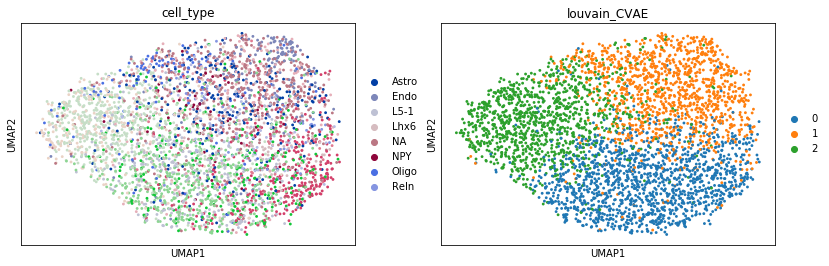

In [78]:
sc.pp.neighbors(post_adata, use_rep="X_CVAE", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
sc.tl.louvain(post_adata, key_added="louvain_CVAE", resolution=0.7)
plt.figure(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type", "louvain_CVAE"])

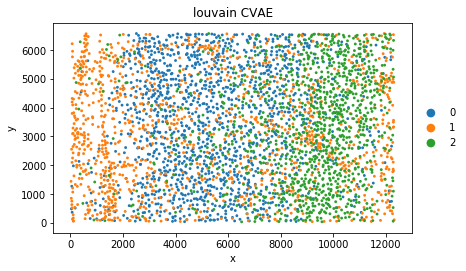

In [79]:
sc.pl.scatter(post_adata, x="x", y="y", color="louvain_CVAE")

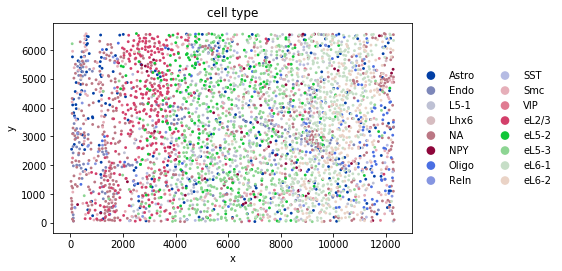

In [80]:
sc.pl.scatter(post_adata, x="x", y="y", color="cell_type")

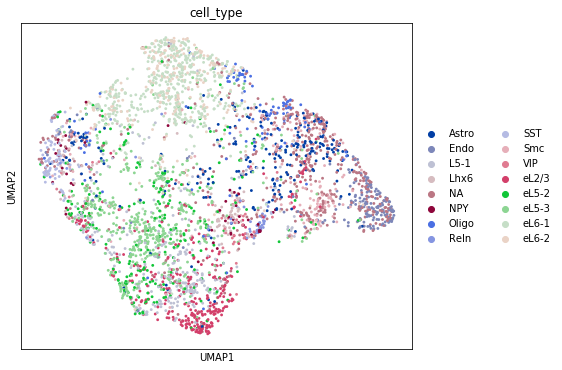

In [75]:
sc.pp.neighbors(post_adata, use_rep="X_VAE", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax)

In this demonstration and for this particular dataset, we use only 558 genes as in the original scVI publication. This was essentially for benchmarking purposes and we propose here a few practical rules for gene filtering with scVI:
+ If many cells are available, it is in general better to use as many genes as possible. Of course, it might be of interest to remove ad-hoc genes depending on the downstream analysis or the application. 
+ When the dataset is small, it is usually better to filter out genes to avoid overfitting. In the original scVI publication, we reported poor imputation performance for when the number of cells was lower than the number of genes. This is all empirical and in general, it is hard to predict what the optimal number of genes will be.
+ The default scVI code will filter genes based on variance. We advise relying on scanpy and then importing the **unnormalized** filtered matrix into scVI for more complex filtering schemes. 

## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


In [4]:
n_epochs = 400 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True

We now create the model and the trainer object. We train the model and output model likelihood every 5 epochs. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [5]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/vae.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

training: 100%|██████████| 400/400 [01:49<00:00,  4.11it/s]


**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

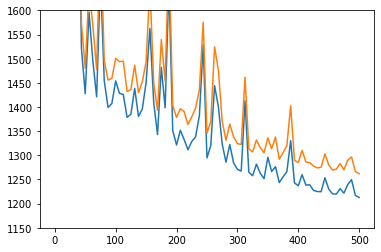

In [6]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)

## Obtaining the posterior object and sample latent space as well as imputation from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [7]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

Similarly, it is possible to query the imputed values via the `imputation` method of the posterior object. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [8]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

## Visualizing the latent space with scanpy

scanpy is a handy and powerful python library for visualization and downstream analysis of single-cell RNA sequencing data. We show here how to feed the latent space of scVI into a scanpy object and visualize it using UMAP as implemented in scanpy. More on how scVI can be used with scanpy on [this notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb). **Note to advanced users:** The code 'get_latent' returns only the mean of the posterior distribution for the latent space. However, we recover a full distribution with our inference framework. Let us keep in mind that the latent space visualized here is a practical summary of the data only. Uncertainty is needed for other downstream analyses such as differential expression. 

In [9]:
import scanpy as sc
import anndata

In [10]:
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([gene_dataset.cell_types[gene_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

... storing 'cell_type' as categorical


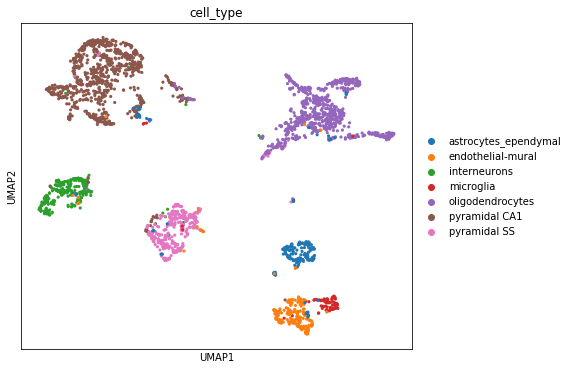

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI for differential expression, which we now discuss.

## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [12]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



**2. Define parameters**
* __n_samples__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [13]:
n_samples = 100
M_permutation = 100000

In [14]:
de_res = full.differential_expression_score(
    cell_idx1, 
    cell_idx2, 
    n_samples=n_samples, 
    M_permutation=M_permutation,
)

**3. Print out the differential expression value**
* bayes1: The bayes factor for cell type 1 having a higher expression than cell type 2
* bayes2: The bayes factor for cell type 2 having a higher expression than cell type 1 (should be ~ -bayes1, but not equal due to ties in comparing per cell expression, and stochasticity of sampling. 
* bayes*i*_permuted: the bayes factor when cell types labels are premuted 
* mean*i*: average UMI counts in cell type *i*
* nonz*i*: proportion of non-zero expression in cell type *i*
* norm_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [15]:
genes_of_interest = ["THY1", "MBP"]
de_res.filter(items=genes_of_interest, axis=0)

,bayes1,bayes1_permuted,bayes2,bayes2_permuted,mean1,mean2,nonz1,nonz2,norm_mean1,norm_mean2,scale1,scale2
THY1,-5.068903,0.00632,5.078609,0.00616,0.589024,13.569755,0.219512,0.996805,0.060620,1.037373,0.000229,0.001811
MBP,5.116705,0.00312,-5.067294,0.01028,55.318295,2.787008,0.998780,0.452609,5.862774,0.210483,0.012763,0.000421


**4. Plot the null distribution of the DE values**

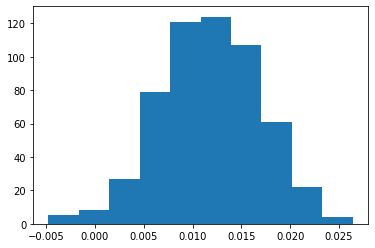

In [16]:
plt.hist(de_res['bayes1_permuted'])

**9. Visualize top 10 most expressed genes per cell types**

In [17]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['norm_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

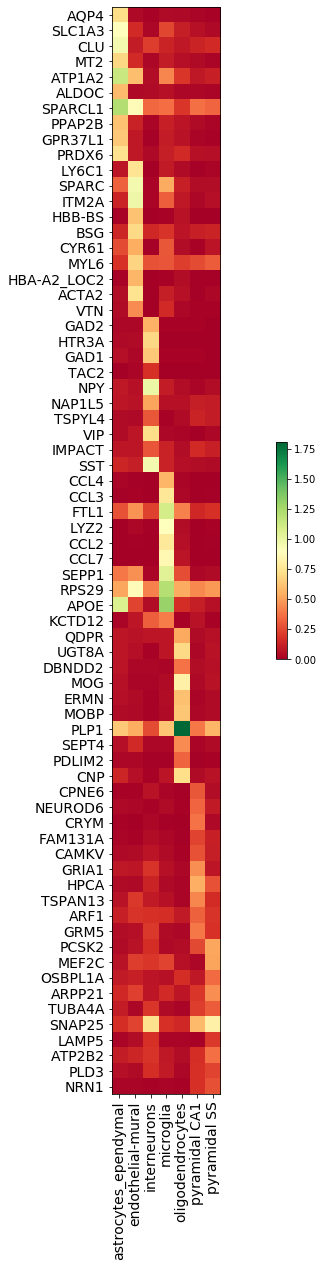

In [18]:
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)

## Correction for batch effects

We now load the RETINA dataset that is described in Shekhar et al. (2016) for an example of batch-effect correction. For more extensive utilization, we encourage the users to visit the [harmonization](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/harmonization.ipynb) as well as the [annotation](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/annotation.ipynb) notebook which explain in depth how to deal with several datasets (in an unsupervised or semi-supervised fashion). 

* Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.

In [19]:
retina_dataset = RetinaDataset(save_path=save_path)

[2019-10-03 13:49:05,908] INFO - scvi.dataset.dataset | File /data/yosef2/users/adamgayoso/software/scVI/data/retina.loom already downloaded
INFO:scvi.dataset.dataset:File /data/yosef2/users/adamgayoso/software/scVI/data/retina.loom already downloaded
[2019-10-03 13:49:05,911] INFO - scvi.dataset.loom | Preprocessing dataset
INFO:scvi.dataset.loom:Preprocessing dataset
[2019-10-03 13:49:17,047] INFO - scvi.dataset.loom | Finished preprocessing dataset
INFO:scvi.dataset.loom:Finished preprocessing dataset
[2019-10-03 13:49:22,877] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
INFO:scvi.dataset.dataset:Remapping labels to [0,N]
[2019-10-03 13:49:22,882] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
INFO:scvi.dataset.dataset:Remapping batch_indices to [0,N]


In [20]:
n_epochs = 50 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = True
use_cuda = True

# Train the model and output model likelihood every 5 epochs
vae = VAE(retina_dataset.nb_genes, n_batch=retina_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae, 
    retina_dataset, 
    train_size=0.9 if not test_mode else 0.5, 
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 50/50 [02:19<00:00,  3.26s/it]


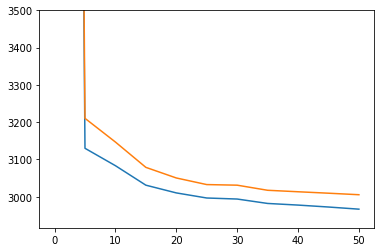

In [21]:
# Plotting the likelihood change across the 50 epochs of training: 
# blue for training error and orange for testing error. 

elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 50, (len(elbo_train)))
plt.plot(x, elbo_train)
plt.plot(x, elbo_test)
plt.ylim(min(elbo_train)-50, 3500)

**Computing batch mixing**

In [22]:
full = trainer.create_posterior(trainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
print("Entropy of batch mixing :", full.entropy_batch_mixing())

Entropy of batch mixing : 0.5934882650315422


**Visualizing the mixing**

In [23]:
full = trainer.create_posterior(trainer.model, retina_dataset, indices=np.arange(len(retina_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()

In [24]:
post_adata = anndata.AnnData(X=retina_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([retina_dataset.cell_types[retina_dataset.labels[i][0]] 
                                   for i in range(post_adata.n_obs)])
post_adata.obs['batch'] = np.array([retina_dataset.batch_indices[i][0] 
                                   for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

... storing 'cell_type' as categorical


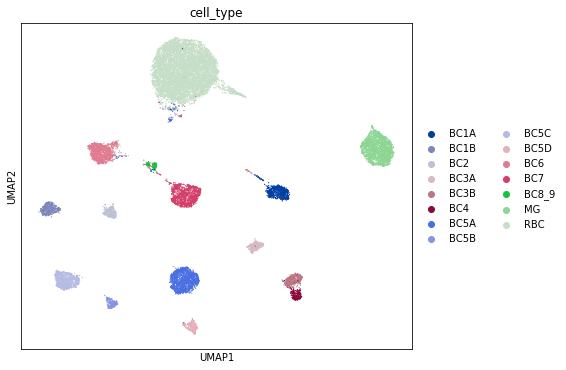

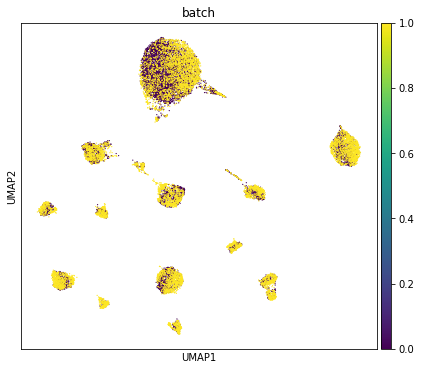

In [25]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

## Logging information

Verbosity varies in the following way:
* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.set_verbosity(level)` to set the verbosity of the scvi package.
Note that `level` corresponds to the logging levels of the standard python `logging` module. By default, that level is set to `INFO` (=20).
As a reminder the logging levels are:
<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>